<a href="https://colab.research.google.com/github/streakcraze/PRODIGY_ML_03/blob/main/comparison_with_1Dneuralnet_(without_edge_detection).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Acquisition

In [5]:
import shutil

shutil.unpack_archive("/content/drive/MyDrive/Colab Notebooks/image-classification-using-svm/dogs-vs-cats/train.zip")

In [6]:
import os

train_images_list = sorted(os.listdir("train"))

print(f"the train dataset has {len(train_images_list)} images")

the train dataset has 25000 images


In [7]:
print(train_images_list[0])
print(train_images_list[-1])

cat.0.jpg
dog.9999.jpg


In [8]:
import re

cat_images = [x for x in train_images_list if re.match("cat", x)]
dog_images = [x for x in train_images_list if re.match("dog", x)]

print(f"{len(cat_images)} cat images")
print(f"{len(dog_images)} dog images")

12500 cat images
12500 dog images


# 2. Data Preprocessing

In [9]:
import numpy as np
from skimage import io, color, transform
import matplotlib.pyplot as plt
import gc

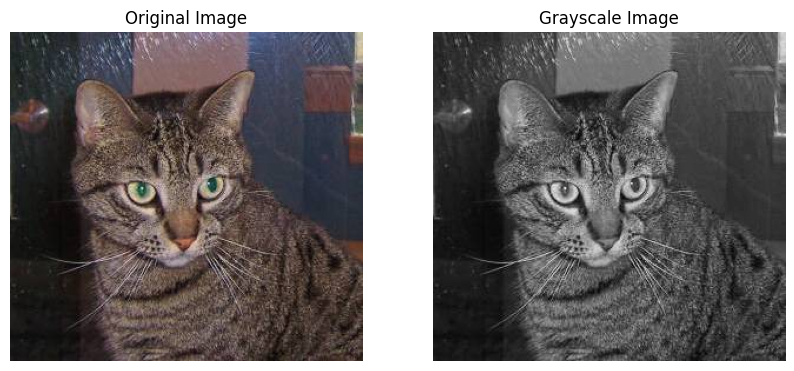

In [10]:
cat_img = io.imread(os.path.join("train", cat_images[1]))
cat_gray = color.rgb2gray(cat_img)

# plotting the original and grayscale images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cat_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.show()

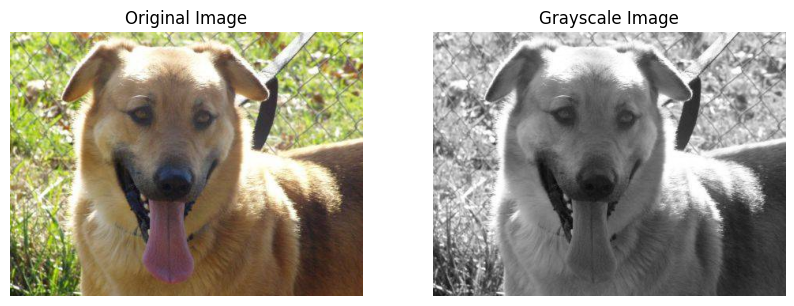

In [11]:
dog_img = io.imread(os.path.join("train", dog_images[10000]))
dog_gray = color.rgb2gray(dog_img)

# plotting the original and grayscale images side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dog_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dog_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.show()

In [12]:
features = np.array([])
# "0" for cat and "1" for dog
labels = np.append(np.full(12500, 0), np.full(12500, 1))

In [13]:
cat_features = []

print("loading cat images ...")

for img in cat_images:
  # load the RGB image
  rgb_img = io.imread(os.path.join("train", img))
  # convert RGB to grayscale
  gray_img = color.rgb2gray(rgb_img)
  # resize the image
  resized_img = transform.resize(gray_img, (50, 50))
  # normalize the image
  normalized_img = resized_img / 255.0
  # flatten the image array
  flat_img = normalized_img.flatten()
  # append to features list
  cat_features.append(flat_img)

features = np.vstack(cat_features)
del cat_features
gc.collect()
print("loaded cat images successfully")

loading cat images ...
loaded cat images successfully


In [14]:
dog_features = []

print("loading dog images ...")

for img in dog_images:
  # load the RGB image
  rgb_img = io.imread(os.path.join("train", img))
  # convert RGB to grayscale
  gray_img = color.rgb2gray(rgb_img)
  # resize the image
  resized_img = transform.resize(gray_img, (50, 50))
  # normalize the image
  normalized_img = resized_img / 255.0
  # flatten the image array
  flat_img = normalized_img.flatten()
  # append to features list
  dog_features.append(flat_img)

features = np.append(features, dog_features, axis=0)
del dog_features
gc.collect()
print("loaded dog images successfully")

loading dog images ...
loaded dog images successfully


In [15]:
from sklearn.decomposition import PCA

In [16]:
print("applying principal component analysis ...")

# Calculate the covariance matrix
cov_matrix = np.cov(features, rowvar=False)
# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
# Sort eigenvalues and corresponding eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]
# Calculate explained variance ratio
total_variance = np.sum(eigenvalues)
explained_variance_ratio = eigenvalues/total_variance
# Choose the number of principal components based on explained variance threshold
variance_threshold = 0.95  # Adjust based on your desired explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
num_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1
# Apply PCA with the chosen number of principal components
pca = PCA(n_components=num_components)
principal_features = pca.fit_transform(features)

# principal_features now contains the reduced-dimensional data using PCA
print(f"features reduced from {len(features[0])} to {len(principal_features[0])}")

del features
gc.collect()
print("principal component analysis completed")

applying principal component analysis ...
features reduced from 2500 to 224
principal component analysis completed


# 3. Model Training

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
print("splitting data into training and test sets")
x_train, x_test, y_train, y_test = train_test_split(principal_features, labels, test_size=0.3, random_state=77, stratify=labels)
del principal_features
del labels
gc.collect()
print("split completed")

splitting data into training and test sets
split completed


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib

In [20]:
model = Sequential()

# Input layer
model.add(Dense(128, input_shape=(num_components,), activation='relu'))

# Hidden layers
model.add(Dense(64, activation='relu'))

# Output layer with 1 neuron and sigmoid activation function for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               28800     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37121 (145.00 KB)
Trainable params: 37121 (145.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
print("model training started")
# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)

joblib.dump(model, "/content/drive/MyDrive/Colab Notebooks/image-classification-using-svm/image_classifier_1Dneuralnet(1).sav")
del x_train
del y_train
gc.collect()
print("model artifact saved")

model training started
Epoch 1/10
547/547 [==============================] - 4s 4ms/step - loss: 0.6868 - accuracy: 0.5461
Epoch 2/10
547/547 [==============================] - 1s 3ms/step - loss: 0.6617 - accuracy: 0.6079
Epoch 3/10
547/547 [==============================] - 1s 2ms/step - loss: 0.6480 - accuracy: 0.6203
Epoch 4/10
547/547 [==============================] - 1s 3ms/step - loss: 0.6413 - accuracy: 0.6285
Epoch 5/10
547/547 [==============================] - 1s 3ms/step - loss: 0.6350 - accuracy: 0.6397
Epoch 6/10
547/547 [==============================] - 2s 3ms/step - loss: 0.6287 - accuracy: 0.6465
Epoch 7/10
547/547 [==============================] - 1s 3ms/step - loss: 0.6244 - accuracy: 0.6539
Epoch 8/10
547/547 [==============================] - 1s 3ms/step - loss: 0.6193 - accuracy: 0.6579
Epoch 9/10
547/547 [==============================] - 2s 4ms/step - loss: 0.6153 - accuracy: 0.6607
Epoch 10/10
547/547 [==============================] - 2s 4ms/step - loss: 0.

# 4. Model Evaluation

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [29]:
# testing the model
y_pred = model.predict(x_test)
binary_y_pred = (y_pred > 0.5).astype(int)

# calculating the accuracy of the model
accuracy = accuracy_score(binary_y_pred, y_test)
print(f"The model is {accuracy*100}% accurate")

235/235 [==============================] - 0s 2ms/step
The model is 61.34666666666667% accurate


In [30]:
# printing the classification report
print("Classification report:")
print(classification_report(y_test, binary_y_pred, target_names=['cat', 'dog']))

Classification report:
              precision    recall  f1-score   support

         cat       0.65      0.48      0.55      3750
         dog       0.59      0.75      0.66      3750

    accuracy                           0.61      7500
   macro avg       0.62      0.61      0.61      7500
weighted avg       0.62      0.61      0.61      7500



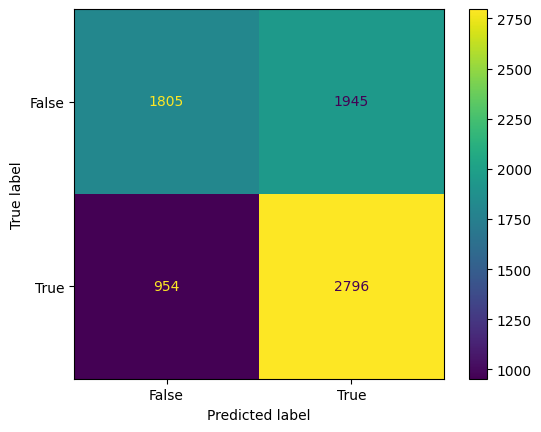

In [31]:
# plotting the confusion matrix
cm = confusion_matrix(y_test, binary_y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.show()

In [32]:
shutil.unpack_archive("/content/drive/MyDrive/Colab Notebooks/image-classification-using-svm/dogs-vs-cats/test1.zip")

In [33]:
test_images_list = sorted(os.listdir("test1"))

print(f"the test dataset has {len(test_images_list)} images")

the test dataset has 12500 images


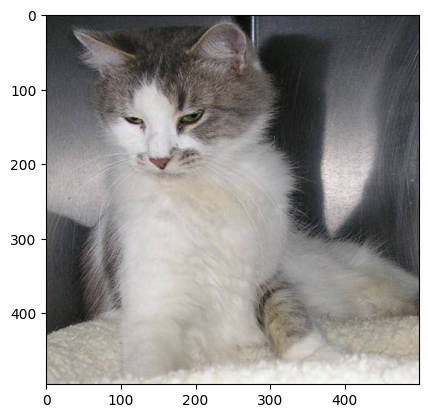

1/1 [==============================] - 0s 83ms/step
Model says it is a cat


In [59]:
test_img = io.imread(os.path.join("test1", test_images_list[8000]))

plt.imshow(test_img)
plt.show()

test_img_features = []

gray_test_img = color.rgb2gray(test_img)
resized_test_img = transform.resize(gray_test_img, (50, 50))
normalized_test_img = resized_test_img / 255.0
flat_test_img = normalized_test_img.flatten()
test_img_features.append(flat_test_img)

for i in range(num_components):
  test_img_features.append(np.full(len(flat_test_img), 1))

principal_test_components = pca.fit_transform(np.vstack(test_img_features))

img_pred = model.predict(np.array([principal_test_components[0]]))

if(img_pred > 0.5):
    print("Model says it is a dog")
else:
    print("Model says it is a cat")

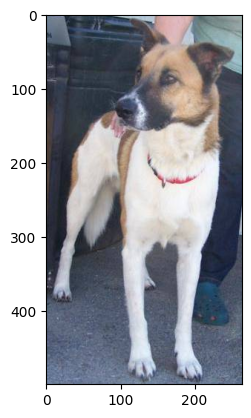

1/1 [==============================] - 0s 104ms/step
Model says it is a cat


In [55]:
test_img = io.imread(os.path.join("test1", test_images_list[70]))

plt.imshow(test_img)
plt.show()

test_img_features = []

gray_test_img = color.rgb2gray(test_img)
resized_test_img = transform.resize(gray_test_img, (50, 50))
normalized_test_img = resized_test_img / 255.0
flat_test_img = normalized_test_img.flatten()
test_img_features.append(flat_test_img)

for i in range(num_components):
  test_img_features.append(np.full(len(flat_test_img), 1))

principal_test_components = pca.fit_transform(np.vstack(test_img_features))

img_pred = model.predict(np.array([principal_test_components[0]]))

if(img_pred > 0.5):
    print("Model says it is a dog")
else:
    print("Model says it is a cat")